# Feature catalog example for spark 

Define multiple features with clear lineage using Hamilton.
Use a custom output builder to join the features of interest together before returning them to the user.

As user you only need to specify which features (groups of features) you want to compute.

## Including column level lineage
By using the `@tag` decorator with the `spark_schema` key you can extend the lineage up to column level, e.g.:

```
@tag(spark_schema="zone:str, level:int, avatarId:int")
```

## Download data
To get started first download the data: 
```
curl https://storage.googleapis.com/shareddatasets/wow.parquet -o data/wow.parquet
```

In [1]:
import findspark
findspark.init()

import importlib
import logging
import sys
import typing

import pyspark.sql as ps

from hamilton import base
from hamilton import driver

logging.basicConfig(stream=sys.stdout)

%load_ext autoreload
%autoreload 2

### Create a customer builder and adapter to create the final output (spark DataFrame)

In [2]:
class MyCustomBuilder(base.ResultMixin):
     @staticmethod
     def build_result(**outputs: typing.Dict[str, typing.Any]) -> ps.DataFrame:
        # TODO: add error handling when incompatible outputs are created
        level_info = outputs['level_info']
        zone_counts = outputs['zone_counts']
        return zone_counts.join(level_info, on=aggregation_level)

adapter = base.SimplePythonGraphAdapter(MyCustomBuilder)

### Create the driver and show the lineage

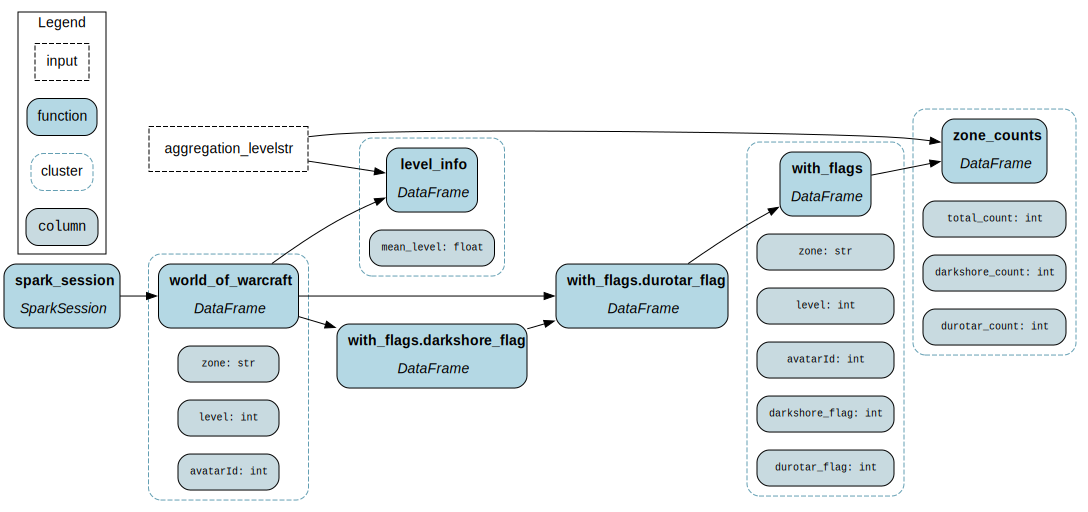

In [3]:
aggregation_level = "avatarId"
zone_features = importlib.import_module("features")

dr = driver.Driver({}, zone_features, adapter=adapter)  # can pass in multiple modules
dr.display_all_functions(deduplicate_inputs=True)

### Compute the features of interest

In [4]:
feature_groups_of_interest = ["level_info", "zone_counts"]
features = dr.execute(feature_groups_of_interest, inputs={"aggregation_level": aggregation_level})
features.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/22 15:52:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/22 15:52:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+--------+-----------+---------------+-------------+------------------+
|avatarId|total_count|darkshore_count|durotar_count|        mean_level|
+--------+-----------+---------------+-------------+------------------+
|      29|       5597|              3|          101| 58.09862426299804|
|    1806|        477|              0|            4|20.041928721174003|
|    9233|       1611|              0|           10| 50.16139044072005|
|    2040|        748|              0|           16|18.259358288770052|
|      26|       2103|              0|           40|55.342368045649074|
|   10422|        217|              0|           47| 14.32258064516129|
|    9978|         53|              0|            9| 7.490566037735849|
|    5385|        370|              0|            5|15.062162162162162|
|    4823|         45|              0|           32|               8.8|
|    9458|        934|              0|           90|28.927194860813703|
|     474|        272|              2|           13|22.327205882